In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import tensorflow as tf
from keras.models import Model
import json

In [2]:
user = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/SonyIndia_ContentBasedRecommender_Hackathon_HE/user.csv")
content = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/SonyIndia_ContentBasedRecommender_Hackathon_HE/content.csv")
relationship = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/SonyIndia_ContentBasedRecommender_Hackathon_HE/relationship.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/SonyIndia_ContentBasedRecommender_Hackathon_HE/test.csv")

In [45]:
user.shape, content.shape, relationship.shape, test.shape

((13843, 5), (48645, 9), (1654450, 6), (1440, 1))

In [41]:
test.shape

(1440, 1)

In [27]:
user.head()

,user_id,user_age,gender,location,joining_date
0,user_45028@domain.com,40,M,Goa,2018-06-18
1,user_95235@domain.com,55,F,Andhra Pradesh,2019-09-17
2,user_44289@domain.com,38,F,Goa,2018-09-03
3,user_23708@domain.com,47,F,West Bengal,2020-11-15
4,user_40584@domain.com,24,M,Tamil Nadu,2018-02-06


In [28]:
user.user_id.nunique()

13843

In [29]:
content.head()

,content_id,content_type,language,genre,duration,release_date,rating,episode_count,season_count
0,cont_475_19_32,series,english,drama,4980000,2018-07-01,10,32,19
1,cont_2185_15_21,series,english,drama,3000000,2016-03-29,4,21,15
2,cont_4857_13_28,series,tamil,comedy,3120000,2006-03-06,8,28,13
3,cont_3340_1_5,sports,hindi,cricket,9900000,2009-01-10,0,5,1
4,cont_1664_10_29,series,hindi,action,3660000,2020-05-25,2,29,10


In [30]:
content.shape

(48645, 9)

In [31]:
content.content_id.nunique()

48645

In [32]:
relationship.head()

,user_id,content_id,duration,date,start_time,end_time
0,user_44902@domain.com,cont_1718_16_7,1920000,2020-06-17,06:19:13,06:51:13
1,user_87018@domain.com,cont_825_1_3,1080000,2019-12-06,19:58:14,20:16:14
2,user_53430@domain.com,cont_1981_2_26,180000,2020-07-27,01:52:51,01:55:51
3,user_53696@domain.com,cont_1072_18_7,1440000,2021-08-24,06:34:14,06:58:14
4,user_80251@domain.com,cont_760_9_27,960000,2020-06-15,16:57:19,17:13:19


In [33]:
relationship.user_id.nunique()

10923

In [34]:
relationship.iloc[0].content_id

'cont_1718_16_7'

In [35]:
relationship[relationship.user_id == "user_44902@domain.com"]

,user_id,content_id,duration,date,start_time,end_time
0,user_44902@domain.com,cont_1718_16_7,1920000,2020-06-17,06:19:13,06:51:13
4328,user_44902@domain.com,cont_1130_6_13,960000,2019-10-19,04:48:55,05:04:55
4482,user_44902@domain.com,cont_1310_9_17,2100000,2019-09-27,07:15:31,07:50:31
5219,user_44902@domain.com,cont_1368_4_26,60000,2019-12-11,16:15:13,16:16:13
7408,user_44902@domain.com,cont_636_1_1,2640000,2020-09-12,22:19:38,23:03:38
...,...,...,...,...,...,...
1647289,user_44902@domain.com,cont_661_3_41,420000,2020-04-09,23:31:18,23:38:18
1649843,user_44902@domain.com,cont_563_1_3,240000,2020-07-09,03:23:46,03:27:46
1652678,user_44902@domain.com,cont_3828_5_40,3960000,2021-07-21,09:48:31,10:54:31
1652969,user_44902@domain.com,cont_265_4_51,360000,2021-12-18,14:08:06,14:14:06


In [36]:
relationship.content_id.nunique()

44223

In [37]:
content[content.content_id == relationship.iloc[0].content_id]

,content_id,content_type,language,genre,duration,release_date,rating,episode_count,season_count
34274,cont_1718_16_7,series,hindi,drama,2880000,2012-04-23,6,7,16


In [38]:
content[content.content_id == relationship.iloc[4328].content_id]

,content_id,content_type,language,genre,duration,release_date,rating,episode_count,season_count
23532,cont_1130_6_13,series,english,comedy,3840000,2012-10-21,7,13,6


In [40]:
test[~test.user_id.isin(relationship.user_id)]

,user_id
11,user_88625@domain.com
16,user_83738@domain.com
19,user_24220@domain.com
20,user_53034@domain.com
27,user_91075@domain.com
...,...
1416,user_35585@domain.com
1418,user_5999@domain.com
1423,user_28539@domain.com
1428,user_35778@domain.com


New DataFrame to combine *relationship* and *content*

In [3]:
combo_df = relationship.merge(content,on='content_id',suffixes=('_watched','_total'))[['user_id','content_id','duration_watched','duration_total']]

Introduce a new parameter *engagement_score* which will be used as target label later. It is defined as the amount of content watched wrt total duration

In [4]:
combo_df['engagement_score'] = combo_df['duration_watched'] / combo_df['duration_total']

In [5]:
combo_df.drop(columns=['duration_watched','duration_total'], inplace=True)

In [6]:
combo_df.head()

,user_id,content_id,engagement_score
0,user_44902@domain.com,cont_1718_16_7,0.666667
1,user_16534@domain.com,cont_1718_16_7,0.458333
2,user_33550@domain.com,cont_1718_16_7,0.625000
3,user_75701@domain.com,cont_1718_16_7,0.916667
4,user_63713@domain.com,cont_1718_16_7,0.187500


In [8]:
combo_df.shape

(1654450, 3)

In [30]:
combo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1654450 entries, 0 to 1654449
Data columns (total 3 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   user_id           1654450 non-null  object 
 1   content_id        1654450 non-null  object 
 2   engagement_score  1654450 non-null  float64
dtypes: float64(1), object(2)
memory usage: 50.5+ MB


In [10]:
combo_df.describe()

,engagement_score
count,1.654450e+06
mean,5.087677e-01
std,2.886282e-01
min,5.464481e-03
25%,2.592593e-01
50%,5.090909e-01
75%,7.592593e-01
max,1.000000e+00


Convert *user_id* and *content_id* to new *int* columns as it will be used inside Neural Networks

In [7]:
combo_df['user_id_int'] = combo_df.user_id.astype('category').cat.rename_categories(range(0, combo_df.user_id.nunique()))
combo_df['content_id_int'] = combo_df.content_id.astype('category').cat.rename_categories(range(0, combo_df.content_id.nunique()))

In [8]:
combo_df.head()

,user_id,content_id,engagement_score,user_id_int,content_id_int
0,user_44902@domain.com,cont_1718_16_7,0.666667,4197,7741
1,user_16534@domain.com,cont_1718_16_7,0.458333,776,7741
2,user_33550@domain.com,cont_1718_16_7,0.625000,2779,7741
3,user_75701@domain.com,cont_1718_16_7,0.916667,7980,7741
4,user_63713@domain.com,cont_1718_16_7,0.187500,6516,7741


Using Embedding for *user_id* and *content_id*. Referring to https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278. 
As mentioned in the article, The aim is to bring user_ids and content_ids in one similar embedding space.

In [9]:
EMBEDDING_SIZE = 10
NUM_USERS = combo_df['user_id_int'].nunique()
NUM_CONTENTS = combo_df['content_id_int'].nunique()
ROW_COUNT = combo_df.shape[0]
UNIQUE_CONTENT_IDS = combo_df['content_id_int'].unique()

Creating ANN with *user_id* and *content_id* embeddings and *engagement_score* as target label.

In [10]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_CONTENTS, NUM_USERS, ROW_COUNT):
    content_input = keras.Input(shape=(1,), name='content_id_int')

    content_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_CONTENTS, input_length=ROW_COUNT, name='content_emb')(content_input)
    content_vec = layers.Flatten(name='FlattenContent')(content_emb)

    content_model = keras.Model(inputs=content_input, outputs=content_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id_int')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([content_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = keras.layers.Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = keras.layers.Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = keras.layers.Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = layers.Dense(1, name='result', activation="relu") (dense_4)

    adam = keras.optimizers.Adam(learning_rate=0.001)
    model = keras.Model([content_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_absolute_error')
    return model, content_model, user_model

In [11]:
model, content_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_CONTENTS, NUM_USERS, ROW_COUNT)

In [38]:
combo_df.isna().sum()

user_id             0
content_id          0
engagement_score    0
user_id_int         0
content_id_int      0
dtype: int64

Training the ANN model

In [12]:
history = model.fit([combo_df.content_id_int, combo_df.user_id_int],combo_df.engagement_score, batch_size=5000,
                              epochs =10,
                              verbose = 1)

Epoch 1/10
331/331 [==============================] - 19s 42ms/step - loss: 0.2612
Epoch 2/10
331/331 [==============================] - 9s 28ms/step - loss: 0.2508
Epoch 3/10
331/331 [==============================] - 12s 37ms/step - loss: 0.2494
Epoch 4/10
331/331 [==============================] - 10s 31ms/step - loss: 0.2445
Epoch 5/10
331/331 [==============================] - 14s 43ms/step - loss: 0.2345
Epoch 6/10
331/331 [==============================] - 9s 28ms/step - loss: 0.2241
Epoch 7/10
331/331 [==============================] - 9s 28ms/step - loss: 0.2153
Epoch 8/10
331/331 [==============================] - 9s 28ms/step - loss: 0.2080
Epoch 9/10
331/331 [==============================] - 10s 30ms/step - loss: 0.2022
Epoch 10/10
331/331 [==============================] - 10s 29ms/step - loss: 0.1977


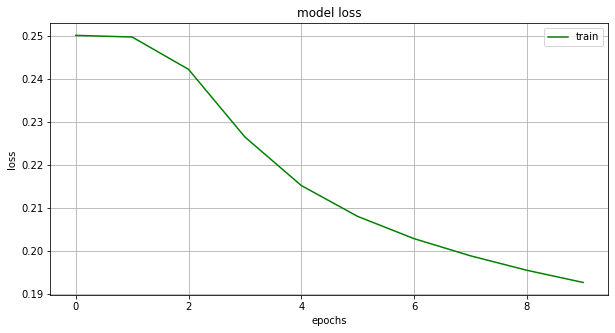

In [51]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

In [13]:
import collections

CONTENT_EMBEDDING_LIST = []
CONTENT_EMBED_MAP = collections.defaultdict()

Store all the content embedding values

In [14]:
count = 1
for _id in UNIQUE_CONTENT_IDS:
    print("Done : ", count)
    emb = content_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    CONTENT_EMBEDDING_LIST.insert(_id, val)
    count += 1
    #CONTENT_EMBED_MAP[_id] = val

Streaming output truncated to the last 5000 lines.
Done :  39224
Done :  39225
Done :  39226
Done :  39227
Done :  39228
Done :  39229
Done :  39230
Done :  39231
Done :  39232
Done :  39233
Done :  39234
Done :  39235
Done :  39236
Done :  39237
Done :  39238
Done :  39239
Done :  39240
Done :  39241
Done :  39242
Done :  39243
Done :  39244
Done :  39245
Done :  39246
Done :  39247
Done :  39248
Done :  39249
Done :  39250
Done :  39251
Done :  39252
Done :  39253
Done :  39254
Done :  39255
Done :  39256
Done :  39257
Done :  39258
Done :  39259
Done :  39260
Done :  39261
Done :  39262
Done :  39263
Done :  39264
Done :  39265
Done :  39266
Done :  39267
Done :  39268
Done :  39269
Done :  39270
Done :  39271
Done :  39272
Done :  39273
Done :  39274
Done :  39275
Done :  39276
Done :  39277
Done :  39278
Done :  39279
Done :  39280
Done :  39281
Done :  39282
Done :  39283
Done :  39284
Done :  39285
Done :  39286
Done :  39287
Done :  39288
Done :  39289
Done :  39290
Done :  392

In [58]:
len(UNIQUE_CONTENT_IDS)

44223

In [56]:
len(CONTENT_EMBED_MAP)

28880

Since *user_ids* and *content_ids* are in a similar embedding space, use KNN to extract the nearest *content_ids* with the help of *user_ids*

In [15]:
knn_train_label = UNIQUE_CONTENT_IDS

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(np.array(CONTENT_EMBEDDING_LIST), knn_train_label)

KNeighborsClassifier(n_neighbors=11)

Takes the *user_embedding* and predicts the top 10 *content_ids* as recommendations

In [93]:
def recommend_movies(embedding):
    distances, indices = clf.kneighbors(embedding.reshape(1, -1),  n_neighbors=10)
    indices = indices.reshape(10,1)
    df_indices = pd.DataFrame(indices, columns = ['content_id_int'])
    return combo_df[combo_df.content_id_int.isin(df_indices.content_id_int)]['content_id'].unique()
    #print(df_indices)
    #return df_indices.merge(combo_df,on='content_id_int',how='inner',suffixes=['_u', '_m'])['content_id']

In [22]:
relationship[~relationship.user_id.isin(user.user_id)]

,user_id,content_id,duration,date,start_time,end_time


In [26]:
user.head()

,user_id,user_age,gender,location,joining_date
0,user_45028@domain.com,40,M,Goa,2018-06-18
1,user_95235@domain.com,55,F,Andhra Pradesh,2019-09-17
2,user_44289@domain.com,38,F,Goa,2018-09-03
3,user_23708@domain.com,47,F,West Bengal,2020-11-15
4,user_40584@domain.com,24,M,Tamil Nadu,2018-02-06


It is to be noted that in **test.csv** there are *user_ids* that are not present in the **relationship.csv**. Hence, using demographics in **user.csv** we will find *user_ids* closest to a specific user_id in **test.csv**. Creating *user_new* to as a copy for *user* so that original is lef untouched

In [45]:
user_new = user.copy()
user_new['gender'] = user_new.gender.map({'M':1, 'F':0})
user_new = pd.get_dummies(data=user_new, columns=['location'])
user_new['year'] = user['joining_date'].str.split('-').str[0].astype(int)

In [46]:
user_new.head()

,user_id,user_age,gender,joining_date,location_Andhra Pradesh,location_Arunachal Pradesh,location_Assam,location_Bihar,location_Chhattisgarh,location_Delhi,...,location_Punjab,location_Rajasthan,location_Sikkim,location_Tamil Nadu,location_Telangana,location_Tripura,location_Uttar Pradesh,location_Uttarakhand,location_West Bengal,year
0,user_45028@domain.com,40,1,2018-06-18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2018
1,user_95235@domain.com,55,0,2019-09-17,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2019
2,user_44289@domain.com,38,0,2018-09-03,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2018
3,user_23708@domain.com,47,0,2020-11-15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2020
4,user_40584@domain.com,24,1,2018-02-06,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2018


Store all unique user_ids of **relationship.csv** and their indices in **user.csv **in a different list

In [42]:
unique_rel_user_ids = relationship.user_id.unique()
unique_rel_user_ids_indices_in_users_new = user_new[user_new.user_id.isin(unique_rel_user_ids)].index

In [49]:
user_new[user_new.user_id.isin(unique_rel_user_ids)]

,user_id,user_age,gender,joining_date,location_Andhra Pradesh,location_Arunachal Pradesh,location_Assam,location_Bihar,location_Chhattisgarh,location_Delhi,...,location_Punjab,location_Rajasthan,location_Sikkim,location_Tamil Nadu,location_Telangana,location_Tripura,location_Uttar Pradesh,location_Uttarakhand,location_West Bengal,year
2,user_44289@domain.com,38,0,2018-09-03,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2018
3,user_23708@domain.com,47,0,2020-11-15,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2020
4,user_40584@domain.com,24,1,2018-02-06,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2018
6,user_97032@domain.com,46,0,2020-07-17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020
8,user_71452@domain.com,18,1,2020-09-26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13838,user_5748@domain.com,58,1,2019-06-18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2019
13839,user_16037@domain.com,52,0,2018-07-07,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2018
13840,user_58718@domain.com,19,0,2019-09-01,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2019
13841,user_82850@domain.com,52,1,2020-01-22,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020


In [43]:
unique_rel_user_ids_indices_in_users_new[0]

2

In [47]:
user_new.drop(columns=['user_id','joining_date']).values

array([[  40,    1,    0, ...,    0,    0, 2018],
       [  55,    0,    1, ...,    0,    0, 2019],
       [  38,    0,    0, ...,    0,    0, 2018],
       ...,
       [  19,    0,    0, ...,    0,    0, 2019],
       [  52,    1,    0, ...,    0,    0, 2020],
       [  19,    1,    0, ...,    0,    0, 2020]])

Make all the attributes of *user_new* wrt unique user_ids of *relationship* as *centroids* and keep the *max_iter* as 1. This is done to ensure that unknown *user_ids* are mapped to closest *user_ids* present in *relationship*. If the *test* *user_id* is absent in *relationship* then the closest *user_id* according to *KNN* of user demographics will be chosen to predict the recommendations

In [59]:
from sklearn.cluster import KMeans
users_arr = user_new.drop(columns=['user_id','joining_date']).values
centroids_arr = user_new[user_new.user_id.isin(unique_rel_user_ids)].drop(columns=['user_id','joining_date']).values

kmeans = KMeans(n_clusters=centroids_arr.shape[0], init=centroids_arr, max_iter=1)
kmeans.fit(users_arr)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ConvergenceWarning: Number of distinct clusters (5238) found smaller than n_clusters (10923). Possibly due to duplicate points in X.
  


KMeans(init=array([[  38,    0,    0, ...,    0,    0, 2018],
       [  47,    0,    0, ...,    0,    1, 2020],
       [  24,    1,    0, ...,    0,    0, 2018],
       ...,
       [  19,    0,    0, ...,    0,    0, 2019],
       [  52,    1,    0, ...,    0,    0, 2020],
       [  19,    1,    0, ...,    0,    0, 2020]]),
       max_iter=1, n_clusters=10923)

In [65]:
def get_np_arr(user_id_test):
  return user_new[user_new.user_id == user_id_test].drop(columns=['user_id','joining_date']).values

In [76]:
idx = kmeans.predict(get_np_arr(test.user_id[0]))
print("Original : ", test.user_id[0], ", Closest : ", user_new.iloc[unique_rel_user_ids_indices_in_users_new[idx]].user_id.values[0])

Original :  user_18085@domain.com , Closest :  user_30676@domain.com


Prediction

In [81]:
combo_df[combo_df.user_id == test.iloc[0].user_id].iloc[0].user_id_int

960

In [110]:
user_embedding = user_model.predict([960]).reshape(1,-1)[0]

In [98]:
def get_user_embedding(user_id_test):
  if user_id_test in relationship.user_id.values:
    user_id_int_test_idx = combo_df[combo_df.user_id == user_id_test].iloc[0].user_id_int
  else:
    user_id_int_test_idx = kmeans.predict(get_np_arr(user_id_test))
  print("User Embedding index = ", user_id_int_test_idx)
  return user_model.predict([user_id_int_test_idx]).reshape(1,-1)[0]

In [109]:
get_user_embedding(test.iloc[0].user_id) 

User Embedding index =  960


array([-0.02257936, -0.05062448, -0.06714473,  0.08544584, -0.14578806,
        0.05176957,  0.00050434,  0.06141018, -0.10670314, -0.07104047],
      dtype=float32)

In [83]:
test.iloc[11].user_id in relationship.user_id.values

False

In [118]:
"cont_2151_7_1" in relationship[relationship.user_id == test.iloc[0].user_id].content_id.values

False

In [111]:
recommend_movies(user_embedding)

array(['cont_2151_7_1', 'cont_3229_6_15', 'cont_4972_10_10',
       'cont_408_4_8', 'cont_1955_1_29', 'cont_28_7_21', 'cont_1873_1_28',
       'cont_658_1_4', 'cont_3146_4_8', 'cont_4427_1_29'], dtype=object)

Store predictions using *json.dumps*

In [106]:
data = {}
for test_user_id in test.user_id.values:
  print("For test_user_id = ", test_user_id)
  user_embedding_test = get_user_embedding(test_user_id)
  print("Recommended Content = ", recommend_movies(user_embedding_test))

  data[test_user_id] = recommend_movies(user_embedding_test).tolist()
json_data = json.dumps(data)

Streaming output truncated to the last 5000 lines.
For test_user_id =  user_15121@domain.com
User Embedding index =  595
Recommended Content =  ['cont_2381_2_4' 'cont_2417_6_13' 'cont_848_1_5' 'cont_3081_12_5'
 'cont_1437_4_39' 'cont_3512_8_17' 'cont_4292_1_5' 'cont_1949_17_12'
 'cont_346_6_1' 'cont_3259_8_1']
For test_user_id =  user_17381@domain.com
User Embedding index =  879
Recommended Content =  ['cont_3970_12_35' 'cont_3081_12_15' 'cont_321_2_12' 'cont_1664_9_21'
 'cont_2796_4_12' 'cont_4047_4_1' 'cont_1835_2_7' 'cont_4218_8_30'
 'cont_1935_39_5' 'cont_1003_2_13']
For test_user_id =  user_10158@domain.com
User Embedding index =  16
Recommended Content =  ['cont_1327_3_2' 'cont_303_1_1' 'cont_1736_1_25' 'cont_343_8_46'
 'cont_2050_1_5' 'cont_3432_4_7' 'cont_1331_2_41' 'cont_4561_2_34'
 'cont_684_10_16' 'cont_1203_15_12']
For test_user_id =  user_16792@domain.com
User Embedding index =  804
Recommended Content =  ['cont_1567_1_16' 'cont_1357_1_4' 'cont_287_8_15' 'cont_4724_4_30'
 

In [ ]:
json_data

Save the json to submission json file

In [108]:
with open("submission1_SuvSanjitPatnaik.json", "w") as outfile:
    outfile.write(json_data)